# Basic Setup

Set up Basic Parameter here

In [68]:
import numpy as np
import random
from mv_laplace import MvLaplaceSampler
import matplotlib.pyplot as plt
import pandas as pd


In [69]:
# Define sample size
N = 20000 # number of subjects
N_T = 10000 # number of treated subjects

# Define betas
beta_11 = 1
beta_12 = 1
beta_21 = 1
beta_22 = 1
beta_23 = 1
beta_31 = 1

#Mask rate - (30%-50%)
lambda1 = 100
lambda2 = 25
lambda3 = 15


# Simulate X
The observed covariates for the $n$-th subject $(X_{n1}, X_{n2}, X_{n3}, X_{n4}, X_{n5})$ are i.i.d. generated through the following process: 


$    (X_{n1}, X_{n2})\sim \mathcal{N}\left[\left(\begin{array}{c}
\frac{1}{2}\\
-\frac{1}{3}
\end{array}\right),\left(\begin{array}{cc}
1 & \frac{1}{2} \\
\frac{1}{2} & 1 
\end{array}\right)\right], (X_{n3}, X_{n4})\sim \text{Laplace}\left[\left(\begin{array}{c}
0\\
\frac{1}{\sqrt{3}}
\end{array}\right),\left(\begin{array}{cc}
1 & \frac{1}{\sqrt{2}} \\
\frac{1}{\sqrt{2}} & 1 
\end{array}\right)\right],
$
$X_{n5} \sim \text{Bernoulli}(1/3)$, for $n=1,\dots, N$



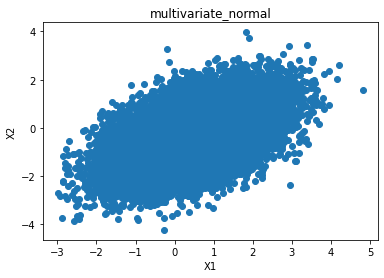

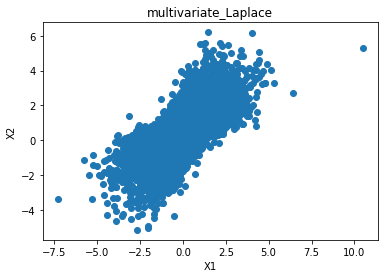

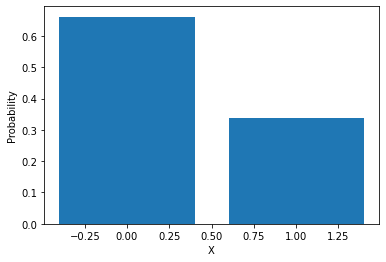

[[ 1.96873453  1.25088246 -0.00823194  0.83694738  0.        ]
 [ 0.11797243 -0.39974719 -2.03759848 -1.1551129   0.        ]
 [ 0.40314603 -0.7912428  -0.78899611  0.27319832  0.        ]
 ...
 [ 2.02711133 -0.94143175  0.1420172   1.64292071  1.        ]
 [ 0.02620352 -0.11070812  1.95656998  1.55393773  0.        ]
 [-1.80946151 -2.96802152 -0.42636847  0.60947895  0.        ]]


In [70]:
# generate Xn1 and Xn2
mean = [1/2, -1/3]
cov = [[1, 1/2], [1/2, 1]]
X1_2 = np.random.multivariate_normal(mean, cov, N)
plt.scatter(X1_2[:, 0], X1_2[:, 1])
plt.xlabel('X1')
plt.ylabel('X2')
plt.title("multivariate_normal")
plt.show()

# generate Xn3 and Xn4
loc = [0, 1/np.sqrt(3)]
cov = [[1,1/np.sqrt(2)], [1/np.sqrt(2),1]]

sampler = MvLaplaceSampler(loc, cov)
X3_4 = sampler.sample(N)
plt.scatter(X3_4[:, 0], X3_4[:, 1])
plt.xlabel('X1')
plt.ylabel('X2')
plt.title("multivariate_Laplace")
plt.show()

# generate Xn5
p = 1/3
X5 = np.random.binomial(1, p, N)

counts = np.unique(X5, return_counts=True)
plt.bar(counts[0], counts[1]/N)
plt.xlabel('X')
plt.ylabel('Probability')
plt.show()

# combine all generated variables into a single matrix
X = np.hstack((X1_2, X3_4, X5.reshape(-1,1)))

print(X)

# Simulate U

The unobserved covariates for the $n$-th subject $(U_{n1}, U_{n2})$ are i.i.d. generated through the following process: $U_{n1}\sim N(1/2, 1)$ and $U_{n2}\sim \text{Bernoulli}(2/3)$, for $n=1,\dots, N$.

In [71]:
# generate Un1
mean = 1/2
std = 1
U_n1 = np.random.normal(mean, std, N)

# generate Un2
U_n2 = np.random.binomial(1, 2/3, N)

U = np.concatenate((U_n1.reshape(-1, 1), U_n2.reshape(-1, 1)), axis=1)

U


array([[ 0.76994451,  1.        ],
       [ 0.05695349,  1.        ],
       [ 1.97944516,  0.        ],
       ...,
       [-0.96325488,  1.        ],
       [ 2.65356512,  1.        ],
       [ 0.06316193,  1.        ]])

# Simulate Z
The observed treatment indicators $\mathbf{Z}=(Z_{1}, \dots, Z_{N})\in \{0, 1\}^{N}$ follow a completely randomized experiment: $P(\mathbf{Z}=\mathbf{z})={N\choose N_{T}}^{-1}$ for any $\mathbf{z}=(z_{1},\dots, z_{N})\in \{0,1\}^{N}$ with $\sum_{n=1}^{N}z_{n}=N_{T}$.

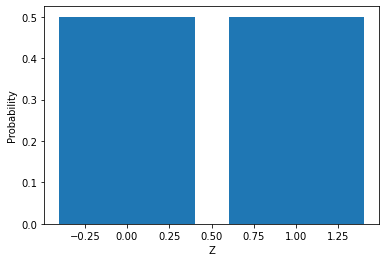

array([1., 1., 1., ..., 0., 1., 1.])

In [72]:
Z = np.zeros(N)
Z[:N_T] = 1
np.random.shuffle(Z)

counts = np.unique(Z, return_counts=True)
plt.bar(counts[0], counts[1]/N)
plt.xlabel('Z')
plt.ylabel('Probability')
plt.show()
Z = Z.reshape(-1,)
Z

# Simulate Y

The three outcomes of interest $(Y_{n1}, Y_{n2}, Y_{n3})$ are generated via the following process (for $n=1,\dots, N$):

\begin{align*}
    
    &Y_{n1}= \beta_{11} Z_{n}+\beta_{12}Z_{n}\cdot \sum_{p=1}^{5}\sqrt{p}\cdot \exp(X_{np})+\sum_{p=1}^{5}\sum_{p^{\prime}=1}^{5}X_{np} X_{np^{\prime}}^{2}+\sin(U_{n1})+U_{n2},\\
    &Y_{n2}= \beta_{21} Z_{n} + \beta_{22}Z_{n} X_{n1}+ \beta_{23}Z_{n} U_{n1}U_{n2}+\sum_{p=1}^{5}(\cos{p})\cdot X_{np}+\sum_{p=1}^{5}\sum_{p^{\prime}=1}^{5}X_{np}\cdot \exp(X_{np^{\prime}}),  \\
    &Y_{n3}= \beta_{31} Z_{n} + \sum_{p=1}^{5}(\sin{p})\cdot X_{np}+\sum_{p=1}^{5}\sum_{p^{\prime}=1}^{5}\sum_{p^{\prime\prime}=1}^{5}X_{np} X_{np^{\prime}}\exp(X_{np^{\prime\prime}})+X_{n1} X_{n2}\cdot \sin (U_{n1}U_{n2}).
   
\end{align*}
    

In [73]:
#def sum1():
sum1 = np.zeros(N)
for p in range(1,6):
  sum1 += np.sqrt(p) * np.exp(X[:,p-1])

#def sum2():
sum2 = np.zeros(N)
for p in range(1,6):
  for p_2 in range(1,6):
    sum2 += X[:,p-1] * np.power(X[:,p_2-1],2)

#def sum3():
sum3 = np.zeros(N)

for p in range(1,6):
  sum3 += np.cos(p) * X[:,p-1]

#def sum4():
sum4 = np.zeros(N)
for p in range(1,6):
  for p_2 in range(1,6):
    sum4 += X[:,p-1] * np.exp(X[:,p_2-1])

#def sum5():
sum5 = np.zeros(N)
for p in range(1,6):
  sum5 += np.sin(p) * X[:,p-1]

#def sum6(): 
sum6 = np.zeros(N)
for p in range(1,6):
  for p_2 in range(1,6):
    for p_3 in range(1,6):
      sum6 += X[:,p-1] * X[:,p_2-1] * np.exp(X[:,p_3-1])


# Calculate Y_n1
Y_n1 = beta_11 * Z + beta_12 * Z * sum1   + sum2 + np.sin(U_n1) + U_n2

# Compute Yn2
Y_n2 = beta_21 * Z + beta_22 * Z * X[:,0] + beta_23 * Z * U_n1 * U_n2 + sum3 + sum4

# Compute Yn3
Y_n3 = beta_31 * Z + sum5 + sum6 + X[:,0] * X[:,1] * np.sin(U_n1 * U_n2)

Y = np.concatenate((Y_n1.reshape(-1, 1), Y_n2.reshape(-1, 1),Y_n3.reshape(-1, 1)), axis=1)
print(Y.shape)

(20000, 3)


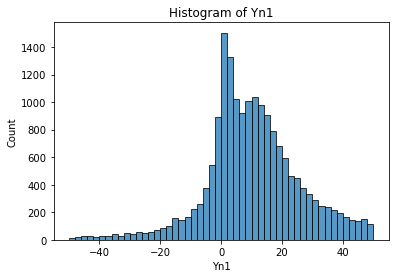

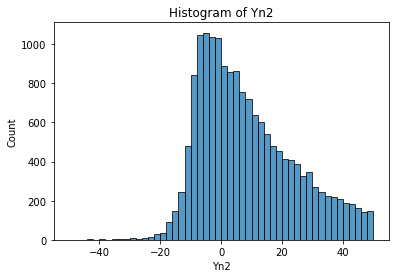

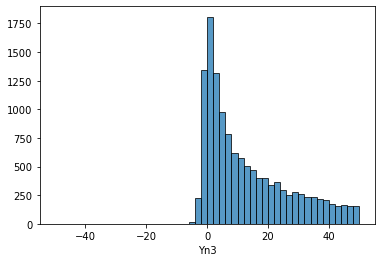

In [74]:
# Plot histogram of Yn1
plt.hist(Y_n1, bins=50, range = (-50,50), edgecolor='black', alpha=0.75)
plt.xlabel('Yn1')
plt.ylabel('Count')
plt.title('Histogram of Yn1')
plt.show()

# Plot histogram of Yn2
plt.hist(Y_n2, bins=50,range = (-50,50), edgecolor='black', alpha=0.75)
plt.xlabel('Yn2')
plt.ylabel('Count')
plt.title('Histogram of Yn2')
plt.show()

# Plot histogram of Yn3
plt.hist(Y_n3, bins=50,range = (-50,50), edgecolor='black', alpha=0.75)
plt.xlabel('Yn3')
plt.show()

#Simulate M

\begin{align*}
            &M_{n1}=\mathbf{1}\Big \{\sum_{p=1}^{5} \exp(X_{np})+\sum_{p=1}^{5}\sum_{p^{\prime}=1}^{5}X_{np} X_{np^{\prime}}^{2}+\sin^{3}(U_{n1})+U_{n2} + \exp(Y_{n1})> \lambda_{1} \} \\
            &M_{n2}=\mathbf{1}\Big \{\sum_{p=1}^{5} X_{np}^{3}+\sum_{p=1}^{5}\sum_{p^{\prime}=1}^{5}X_{np}X_{np^{\prime}}+U_{n1}+ \frac{1}{2}\cdot Y_{n1}^{3}+Y_{n2}>\lambda_{2} \} \\
            &  M_{n3}=\mathbf{1}\Big \{\sum_{p=1}^{5}p\cdot X_{np}+\sum_{p=1}^{5}\sum_{p^{\prime}=1}^{5}\sum_{p^{\prime\prime}=1}^{5}X_{np} X_{np^{\prime}}X_{np^{\prime\prime}}+\sin(U_{n1})\cdot U_{n2} + Y_{n1} + \exp(Y_{n2}) > \lambda_{3} \}. 
\end{align*}






In [75]:

def missing_dataset_indicator(X, U, Y, lambda1, lambda2, lambda3):
    n = X.shape[0]
    M = np.zeros((n, 3))
    M_lamda = np.zeros((n, 3))

    for i in range(n):
        sum1 = 0
        for p in range(1,6):
          for p_2 in range(1,6):
            sum1 += X[i,p-1] * np.power(X[i,p_2-1],2)
          
        sum2 = 0
        for p in range(1,6):
          for p_2 in range(1,6):
            sum2 += X[i,p-1] * X[i,p_2-1]

        sum3 = 0
        for p in range(1,6):
            sum3 += p * X[i,p-1] 

        sum4 = 0
        for p in range(1,6):
          for p_2 in range(1,6):
            for p_3 in range(1,6):
              sum4 += X[i,p-1] * X[i,p_2-1] * X[i,p_3-1]

        M_lamda[i][0] = np.exp(X[i, :]).sum() + sum1 + np.sin(U[i, 0])**3 + U[i, 1] + np.exp(Y[i, 0])

        M_lamda[i][1] = ((X[i, :]**3).sum() + sum2 + U[i, 0] + (Y[i, 0]**3)/2 + Y[i, 1])

        M_lamda[i][2] = (sum3 + sum4 + np.sin(U[i, 0]) * U[i, 1] + Y[i, 0] + np.exp(Y[i, 1]))

        if (np.exp(X[i, :]).sum() + sum1 + np.sin(U[i, 0])**3 + U[i, 1] + np.exp(Y[i, 0])) > lambda1:
          M[i][0] = 1 
        else:
          M[i][0] = 0 
        
        if ((X[i, :]**3).sum() + sum2 + U[i, 0] + (Y[i, 0]**3)/2 + Y[i, 1]) > lambda2:
          M[i][1] = 1 
        else:
          M[i][1] = 0 

        if (sum3 + sum4 + np.sin(U[i, 0]) * U[i, 1] + Y[i, 0] + np.exp(Y[i, 1])) > lambda3:
          M[i][2] = 1 
        else:
          M[i][2] = 0 

    return M,M_lamda
M,M_lamda = missing_dataset_indicator(X,U,Y,lambda1,lambda2,lambda3)
display(pd.DataFrame(M))
print(M_lamda)


/var/folders/gl/3msbrfh11bx8rfwqwpc91jm40000gn/T/ipykernel_33101/3497366358.py:31: RuntimeWarning: overflow encountered in exp
  M_lamda[i][2] = (sum3 + sum4 + np.sin(U[i, 0]) * U[i, 1] + Y[i, 0] + np.exp(Y[i, 1]))
/var/folders/gl/3msbrfh11bx8rfwqwpc91jm40000gn/T/ipykernel_33101/3497366358.py:43: RuntimeWarning: overflow encountered in exp
  if (sum3 + sum4 + np.sin(U[i, 0]) * U[i, 1] + Y[i, 0] + np.exp(Y[i, 1])) > lambda3:
/var/folders/gl/3msbrfh11bx8rfwqwpc91jm40000gn/T/ipykernel_33101/3497366358.py:27: RuntimeWarning: overflow encountered in exp
  M_lamda[i][0] = np.exp(X[i, :]).sum() + sum1 + np.sin(U[i, 0])**3 + U[i, 1] + np.exp(Y[i, 0])
/var/folders/gl/3msbrfh11bx8rfwqwpc91jm40000gn/T/ipykernel_33101/3497366358.py:33: RuntimeWarning: overflow encountered in exp
  if (np.exp(X[i, :]).sum() + sum1 + np.sin(U[i, 0])**3 + U[i, 1] + np.exp(Y[i, 0])) > lambda1:


,0,1,2
0,1.0,1.0,1.0
1,0.0,0.0,0.0
2,1.0,1.0,0.0
3,1.0,1.0,1.0
4,1.0,1.0,0.0
...,...,...,...
19995,0.0,0.0,1.0
19996,1.0,1.0,1.0
19997,1.0,1.0,1.0
19998,1.0,1.0,1.0


[[ 8.85059822e+20  5.61939493e+04  8.33578093e+27]
 [-1.54236726e+01 -9.68213637e+02 -6.57438978e+01]
 [ 4.29193388e+03  2.92692105e+02  5.35198159e+00]
 ...
 [ 5.33630680e+14  1.95910016e+04  7.20361114e+28]
 [ 5.99021172e+21  6.31199906e+04  1.79421874e+22]
 [-5.33493053e+01 -5.78204101e+04 -1.52214446e+02]]


[ 8.85059822e+20 -1.54236726e+01  4.29193388e+03 ...  5.33630680e+14
  5.99021172e+21 -5.33493053e+01]
[8.85059822e+20 5.61939493e+04 8.33578093e+27]


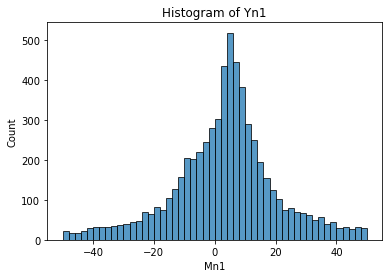

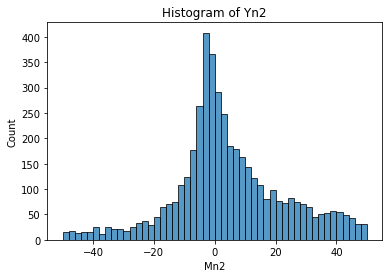

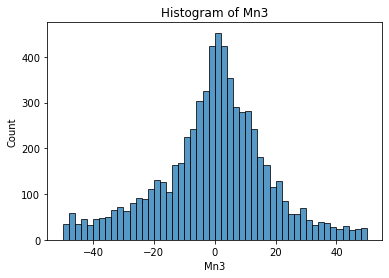

In [76]:
# Plot histogram of Mn1
print(M_lamda[:,0])
print(M_lamda[0,:])

plt.hist(M_lamda[:,0], bins=50, range = (-50,50), edgecolor='black', alpha=0.75)
plt.xlabel('Mn1')
plt.ylabel('Count')
plt.title('Histogram of Yn1')
plt.show()

# Plot histogram of Mn2
plt.hist(M_lamda[:,1], bins=50, range = (-50,50), edgecolor='black', alpha=0.75)
plt.xlabel('Mn2')
plt.ylabel('Count')
plt.title('Histogram of Yn2')
plt.show()

# Plot histogram of Mn3
plt.hist(M_lamda[:,2], bins=50, range = (-50,50), edgecolor='black', alpha=0.75)
plt.xlabel('Mn3')
plt.ylabel('Count')
plt.title('Histogram of Mn3')
plt.show()

In [77]:
print(M[:,0].sum() / N)

print(M[:,1].sum() / N)

print(M[:,2].sum() / N)

0.65505
0.6948
0.6676


# Save all the simulated data


In [78]:
# Read the data,it is important to put the "Research" directory in ones own google drive
np.save("/Users/jiaweizhang/research/data/X.npy", X)
np.save("/Users/jiaweizhang/research/data/Y.npy", Y)
np.save("/Users/jiaweizhang/research/data/Z.npy", Z)
np.save("/Users/jiaweizhang/research/data/U.npy", U)
np.save("/Users/jiaweizhang/research/data/M.npy", M)

print(X.shape)
display(pd.DataFrame(X))
print(pd.DataFrame(X).describe())
print(Y.shape)
display(pd.DataFrame(Y))
print(pd.DataFrame(Y).describe())
print(Z.shape)
display(pd.DataFrame(Z))
print(pd.DataFrame(Z).describe())
print(U.shape)
display(pd.DataFrame(U))
print(pd.DataFrame(U).describe())
print(M.shape)
display(pd.DataFrame(M))
print(pd.DataFrame(M).describe())


print("Sucessfully Saved")

(20000, 5)


,0,1,2,3,4
0,1.968735,1.250882,-0.008232,0.836947,0.0
1,0.117972,-0.399747,-2.037598,-1.155113,0.0
2,0.403146,-0.791243,-0.788996,0.273198,0.0
3,-0.800229,-0.391292,-0.203083,1.040222,1.0
4,0.275513,-0.601098,-0.599016,0.269714,0.0
...,...,...,...,...,...
19995,-0.334818,-0.042287,0.447035,0.612868,0.0
19996,0.315244,-0.002421,0.286969,1.780765,0.0
19997,2.027111,-0.941432,0.142017,1.642921,1.0
19998,0.026204,-0.110708,1.956570,1.553938,0.0


                  0             1             2             3             4
count  20000.000000  20000.000000  20000.000000  20000.000000  20000.000000
mean       0.495392     -0.341653     -0.002677      0.576674      0.338850
std        1.005362      1.000259      0.991679      1.001394      0.473331
min       -2.979590     -4.229622     -7.268357     -5.161755      0.000000
25%       -0.187108     -1.013776     -0.491731      0.080784      0.000000
50%        0.490746     -0.340625     -0.001580      0.574040      0.000000
75%        1.170325      0.329097      0.497952      1.070437      1.000000
max        4.805306      3.968671     10.470917      6.203703      1.000000
(20000, 3)


,0,1,2
0,48.232187,64.290355,249.989860
1,-12.442706,-7.083779,40.446066
2,8.363526,-1.712051,4.156605
3,19.191582,5.420550,1.553134
4,9.187136,-1.146317,2.446474
...,...,...,...
19995,2.400543,3.147297,2.128416
19996,28.342436,24.370663,60.225367
19997,33.910725,66.446965,255.272269
19998,50.144414,51.241442,172.876204


                  0              1             2
count  20000.000000   20000.000000  2.000000e+04
mean      18.189477      60.447839  6.811920e+02
std       49.215490    4250.781824  7.198921e+04
min     -611.744161     -70.978399 -6.375238e+00
25%        1.669211      -2.144077  4.591436e+00
50%       10.769978       9.482134  2.317285e+01
75%       24.028347      31.701978  9.038024e+01
max     2376.840130  600975.265649  1.018005e+07
(20000,)


,0
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0
...,...
19995,0.0
19996,1.0
19997,0.0
19998,1.0


                  0
count  20000.000000
mean       0.500000
std        0.500013
min        0.000000
25%        0.000000
50%        0.500000
75%        1.000000
max        1.000000
(20000, 2)


,0,1
0,0.769945,1.0
1,0.056953,1.0
2,1.979445,0.0
3,0.850027,1.0
4,-0.143645,1.0
...,...,...
19995,1.194045,1.0
19996,-0.984952,1.0
19997,-0.963255,1.0
19998,2.653565,1.0


                  0             1
count  20000.000000  20000.000000
mean       0.498481      0.671050
std        0.991170      0.469844
min       -2.998840      0.000000
25%       -0.171344      0.000000
50%        0.498694      1.000000
75%        1.150959      1.000000
max        4.767954      1.000000
(20000, 3)


,0,1,2
0,1.0,1.0,1.0
1,0.0,0.0,0.0
2,1.0,1.0,0.0
3,1.0,1.0,1.0
4,1.0,1.0,0.0
...,...,...,...
19995,0.0,0.0,1.0
19996,1.0,1.0,1.0
19997,1.0,1.0,1.0
19998,1.0,1.0,1.0


                  0             1             2
count  20000.000000  20000.000000  20000.000000
mean       0.655050      0.694800      0.667600
std        0.475364      0.460504      0.471085
min        0.000000      0.000000      0.000000
25%        0.000000      0.000000      0.000000
50%        1.000000      1.000000      1.000000
75%        1.000000      1.000000      1.000000
max        1.000000      1.000000      1.000000
Sucessfully Saved
